## Forecasting Total Quantity for six months using Time Series 

#### Importing Tools  

In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from math import sqrt

### Reading the  ExistingCustomersTransactionsData file

In [2]:
timeseries = pd.read_csv('ExistingCustomersTransactionsData.csv')

#### The Dataset contains the following attributes 


1. BillNumber (datatype:object)
2. BillDate (datatype:object)
3. CustomerID (datatype:object)
4. ProductID (datatype:object)
5. ProductCategory (datatype:object)(Contains 3 different categories: 'Office Supplies','Furniture','Technology')
6. Sales (datatype:float)
7. Quantity (datatype:Int)

##### The dataset contains 29982 observations and 7 attributes

####  Checking the First 5 observations and Last 5 observations of the dataset 

In [3]:
timeseries.head()

,BillNumber,BillDate,CustomerID,ProductID,ProductCategory,Sales,Quantity
0,B32607,2014-01-03,C14797,PR7138,Office Supplies,16.448,2
1,B37616,2014-01-03,C13917,PR7138,Office Supplies,16.448,2
2,B42625,2014-01-03,C14353,PR7138,Office Supplies,16.448,2
3,B32712,2014-01-04,C13351,PR7099,Office Supplies,11.784,3
4,B32712,2014-01-04,C13351,PR7490,Office Supplies,272.736,3


In [4]:
timeseries.tail()

,BillNumber,BillDate,CustomerID,ProductID,ProductCategory,Sales,Quantity
29977,B45666,2017-12-30,C13895,PR6943,Office Supplies,20.720,2
29978,B46497,2017-12-30,C12586,PR7046,Office Supplies,3.024,3
29979,B46232,2017-12-30,C14359,PR6143,Furniture,323.136,4
29980,B46232,2017-12-30,C14359,PR7962,Technology,90.930,7
29981,B46232,2017-12-30,C14359,PR6896,Office Supplies,52.776,3


#### Getting the summary of the dataset 

In [5]:
timeseries.describe()

,Sales,Quantity
count,29982.000000,29982.000000
mean,229.858001,3.789574
std,623.224312,2.225035
min,0.444000,1.000000
25%,17.280000,2.000000
50%,54.490000,3.000000
75%,209.940000,5.000000
max,22638.480000,14.000000


#### Checking the Shape of the dataset 

In [6]:
timeseries.shape

(29982, 7)

#### Getting the Column names 

In [7]:
timeseries.columns

Index(['BillNumber', 'BillDate', 'CustomerID', 'ProductID', 'ProductCategory',
       'Sales', 'Quantity'],
      dtype='object')

#### Checking the data type 

In [8]:
timeseries.dtypes

BillNumber          object
BillDate            object
CustomerID          object
ProductID           object
ProductCategory     object
Sales              float64
Quantity             int64
dtype: object

In [9]:
timeseries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29982 entries, 0 to 29981
Data columns (total 7 columns):
BillNumber         29982 non-null object
BillDate           29982 non-null object
CustomerID         29982 non-null object
ProductID          29982 non-null object
ProductCategory    29982 non-null object
Sales              29982 non-null float64
Quantity           29982 non-null int64
dtypes: float64(1), int64(1), object(5)
memory usage: 1.6+ MB


#### Checking the  count of each category present in the Product category column

In [10]:
timeseries.ProductCategory.value_counts()

Office Supplies    18078
Furniture           6363
Technology          5541
Name: ProductCategory, dtype: int64

#### Checking for the unique values in each attribute 

In [11]:
for i in timeseries.columns:
    unique_value = timeseries[i].nunique()
    print(i)
    print(unique_value)

BillNumber
15027
BillDate
1237
CustomerID
2379
ProductID
1862
ProductCategory
3
Sales
5825
Quantity
14


#### Converting the 'BillDate' attribute from object to datetime format 

In [12]:
timeseries['BillDate'] = pd.to_datetime(timeseries['BillDate'])

#### After converting the 'BillDate' column into datetime format 

In [13]:
timeseries.dtypes

BillNumber                 object
BillDate           datetime64[ns]
CustomerID                 object
ProductID                  object
ProductCategory            object
Sales                     float64
Quantity                    int64
dtype: object

#### Checking for the Null values  

In [14]:
timeseries.isnull().sum()

BillNumber         0
BillDate           0
CustomerID         0
ProductID          0
ProductCategory    0
Sales              0
Quantity           0
dtype: int64

#### Since we had to Forecast for Furniture for 6 months, we need to extract Furniture from productcategory attribute and create a dataframe

In [15]:
furniture = timeseries.loc[timeseries['ProductCategory'] == 'Furniture']

#### Checking for the head of the data 

In [16]:
furniture.head()

,BillNumber,BillDate,CustomerID,ProductID,ProductCategory,Sales,Quantity
17,B33327,2014-01-06,C13559,PR6230,Furniture,2573.820,9
26,B38336,2014-01-06,C14305,PR6230,Furniture,2573.820,9
35,B43345,2014-01-06,C14916,PR6230,Furniture,2573.820,9
42,B32629,2014-01-07,C14300,PR6423,Furniture,76.728,3
44,B37638,2014-01-07,C13236,PR6423,Furniture,76.728,3


#### Columns to be dropped

In [17]:
columns_to_drop = ['BillNumber','CustomerID','ProductID','ProductCategory','Sales']

#### Dropping  the attributes, which cannot be used to forecast Total Quantity 

In [18]:
furniture = furniture.drop(columns_to_drop,axis=1)

#### checking the head of the dataset after dropping the columns 

In [19]:
furniture.head()

,BillDate,Quantity
17,2014-01-06,9
26,2014-01-06,9
35,2014-01-06,9
42,2014-01-07,3
44,2014-01-07,3


#### taking the sum of the Quantity and grouping it by billdate 

In [20]:
furniture = furniture.groupby('BillDate')['Quantity'].sum().reset_index()

#### Indexing the Billdate 

In [21]:
furniture = furniture.set_index('BillDate')
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='BillDate', length=889, freq=None)

#### Aggegrating the Quantity month wise, as we have to forecast month wise 

In [22]:
Furniture = furniture['Quantity'].resample('MS').sum()

#### Checking if the quantity is aggregated month wise 

In [23]:
Furniture

BillDate
2014-01-01     210
2014-02-01      69
2014-03-01     393
2014-04-01     243
2014-05-01     291
2014-06-01     366
2014-07-01     342
2014-08-01     321
2014-09-01     624
2014-10-01     390
2014-11-01     684
2014-12-01     936
2015-01-01     264
2015-02-01     135
2015-03-01     333
2015-04-01     321
2015-05-01     378
2015-06-01     336
2015-07-01     486
2015-08-01     336
2015-09-01     615
2015-10-01     420
2015-11-01     930
2015-12-01     771
2016-01-01     303
2016-02-01     207
2016-03-01     486
2016-04-01     438
2016-05-01     543
2016-06-01     384
2016-07-01     477
2016-08-01     345
2016-09-01     852
2016-10-01     561
2016-11-01     954
2016-12-01    1029
2017-01-01     258
2017-02-01     213
2017-03-01     369
2017-04-01     525
2017-05-01     552
2017-06-01     528
2017-07-01     549
2017-08-01     381
2017-09-01     906
2017-10-01     756
2017-11-01    1092
2017-12-01    1182
Freq: MS, Name: Quantity, dtype: int64

#### Displaying month wise 

In [24]:
Furniture['2014']

BillDate
2014-01-01    210
2014-02-01     69
2014-03-01    393
2014-04-01    243
2014-05-01    291
2014-06-01    366
2014-07-01    342
2014-08-01    321
2014-09-01    624
2014-10-01    390
2014-11-01    684
2014-12-01    936
Freq: MS, Name: Quantity, dtype: int64

In [25]:
Furniture['2015']

BillDate
2015-01-01    264
2015-02-01    135
2015-03-01    333
2015-04-01    321
2015-05-01    378
2015-06-01    336
2015-07-01    486
2015-08-01    336
2015-09-01    615
2015-10-01    420
2015-11-01    930
2015-12-01    771
Freq: MS, Name: Quantity, dtype: int64

In [26]:
Furniture['2016']

BillDate
2016-01-01     303
2016-02-01     207
2016-03-01     486
2016-04-01     438
2016-05-01     543
2016-06-01     384
2016-07-01     477
2016-08-01     345
2016-09-01     852
2016-10-01     561
2016-11-01     954
2016-12-01    1029
Freq: MS, Name: Quantity, dtype: int64

In [27]:
Furniture['2017']

BillDate
2017-01-01     258
2017-02-01     213
2017-03-01     369
2017-04-01     525
2017-05-01     552
2017-06-01     528
2017-07-01     549
2017-08-01     381
2017-09-01     906
2017-10-01     756
2017-11-01    1092
2017-12-01    1182
Freq: MS, Name: Quantity, dtype: int64

#### Visualizing the data in time series format 

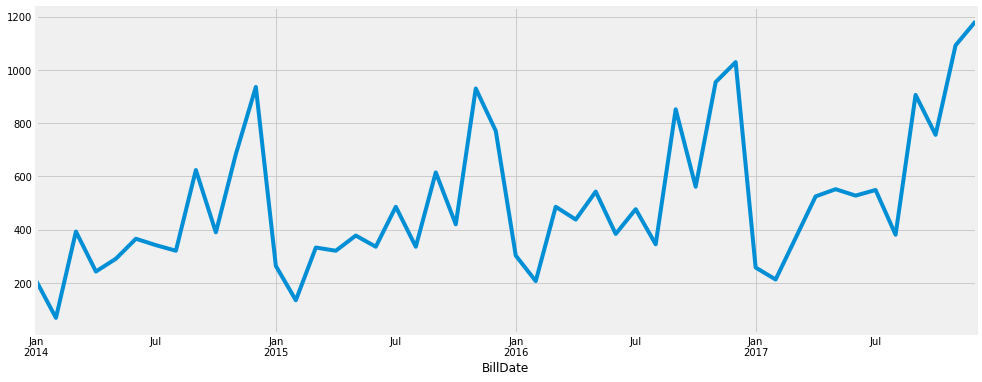

In [28]:
Furniture.plot(figsize=(15, 6))
plt.show()

#### Decomposing in order to understand the seasonality, trend and randomness 

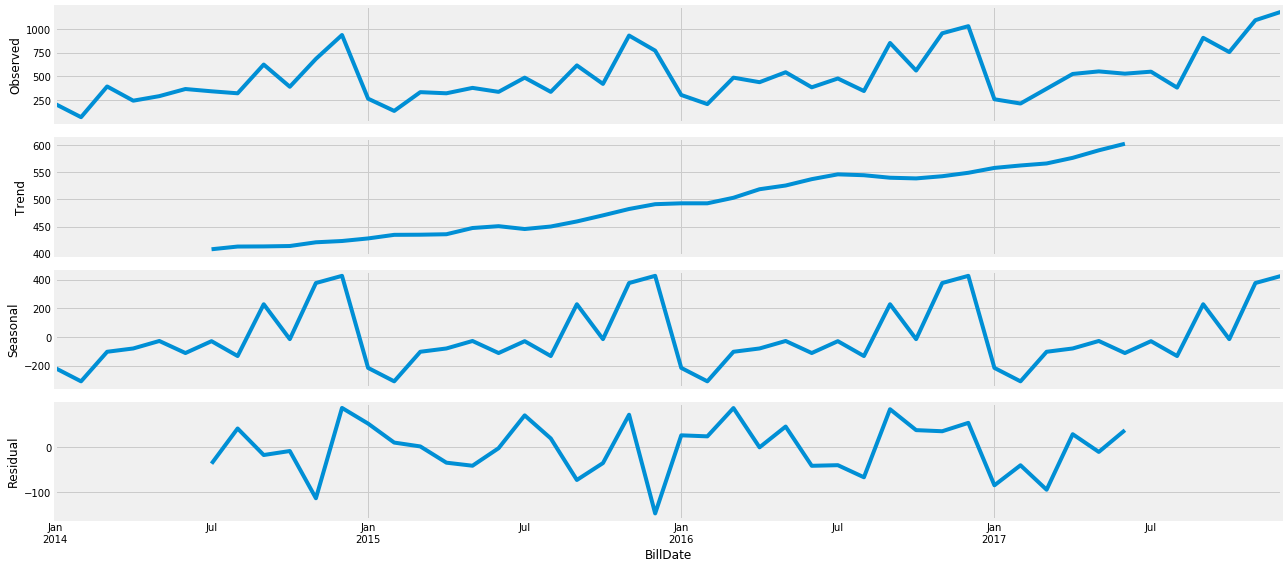

In [29]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(Furniture, model='additive')
fig = decomposition.plot()
plt.show()

#### Parameter Selection for the ARIMA Time Series Model 

In [30]:
p = d = q = range(0, 2)
S = [6,12]
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], x[3]) for x in list(itertools.product(p, d, q,S))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 0, 12)
SARIMAX: (0, 0, 1) x (0, 0, 1, 6)
SARIMAX: (0, 1, 0) x (0, 0, 1, 12)
SARIMAX: (0, 1, 0) x (0, 1, 0, 6)


#### Grid search to get the optimal p,d,q  and P,D,Q,S values 

In [31]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(Furniture,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 6)12 - AIC:732.1449709528243
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:732.1449709528243
ARIMA(0, 0, 0)x(0, 0, 1, 6)12 - AIC:633.1393817363614
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1522.357888733915
ARIMA(0, 0, 0)x(0, 1, 0, 6)12 - AIC:597.7834393664335
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:434.9522910290901
ARIMA(0, 0, 0)x(0, 1, 1, 6)12 - AIC:488.474444704321
ARIMA(0, 0, 0)x(1, 0, 0, 6)12 - AIC:613.2640245188283
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:434.8270071743497
ARIMA(0, 0, 0)x(1, 0, 1, 6)12 - AIC:565.8426568142402
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1560.6493477923161
ARIMA(0, 0, 0)x(1, 1, 0, 6)12 - AIC:448.511111401598
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:301.3945496419233
ARIMA(0, 0, 0)x(1, 1, 1, 6)12 - AIC:429.34210182228554
ARIMA(0, 0, 1)x(0, 0, 0, 6)12 - AIC:687.160388942162
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:687.160388942162
ARIMA(0, 0, 1)x(0, 0, 1, 6)12 - AIC:597.2850417573811
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2740.021913150527
ARIMA(0, 0, 1)x(0, 1, 

#### Fitting an ARIMA Time Series Model after selecting the appropriate parameter for the model 

In [32]:
mod = sm.tsa.statespace.SARIMAX(Furniture,
                                order=(0, 0, 0),
                                seasonal_order=(0, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.378e+04   3644.705      3.781      0.000    6638.493    2.09e+04


#### Validating Forecasts for the year 2017
##### Actual vs forecasted

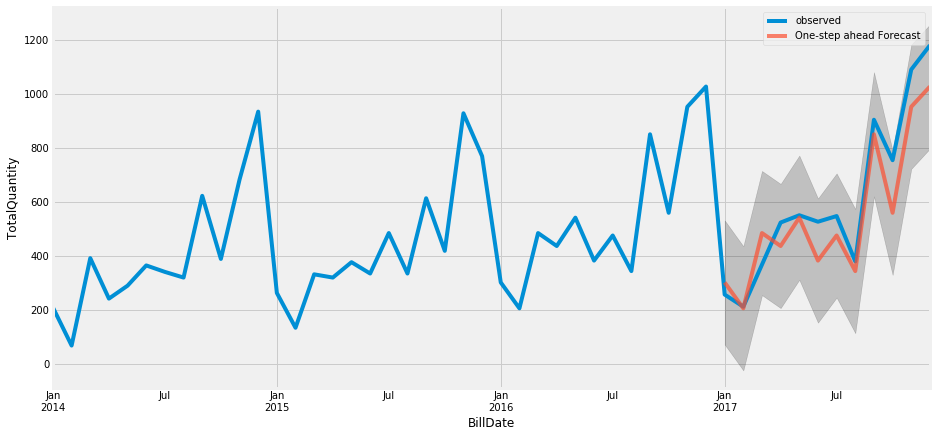

In [33]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = Furniture['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('BillDate')
ax.set_ylabel('TotalQuantity')
plt.legend()
plt.show()

#### Calculating the RMSE  

In [34]:
y_forecasted = pred.predicted_mean
y_truth = Furniture['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 11167.5


#### Calculating the rmse

In [35]:
rmse = sqrt(mse)
rmse

105.67639282261672

#### Forecasting for the year 2017 and comparing it with the actual values

In [36]:
y_forecasted

BillDate
2017-01-01     303.0
2017-02-01     207.0
2017-03-01     486.0
2017-04-01     438.0
2017-05-01     543.0
2017-06-01     384.0
2017-07-01     477.0
2017-08-01     345.0
2017-09-01     852.0
2017-10-01     561.0
2017-11-01     954.0
2017-12-01    1029.0
Freq: MS, dtype: float64

In [37]:
y_truth

BillDate
2017-01-01     258
2017-02-01     213
2017-03-01     369
2017-04-01     525
2017-05-01     552
2017-06-01     528
2017-07-01     549
2017-08-01     381
2017-09-01     906
2017-10-01     756
2017-11-01    1092
2017-12-01    1182
Freq: MS, Name: Quantity, dtype: int64

#### Producing and Visualizing Actual quantity and forecasted quantity

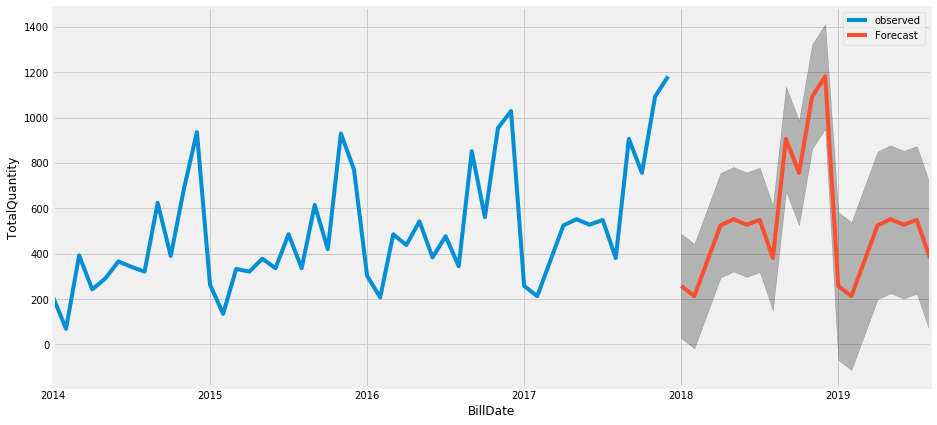

In [38]:
pred_uc = results.get_forecast(steps=20)
pred_ci = pred_uc.conf_int()
ax = Furniture.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('BillDate')
ax.set_ylabel('TotalQuantity')
plt.legend()
plt.show()

#### Using the model to forecast for the next 6 months 

In [39]:
forecast = results.predict(start=48, end=53) 
print (forecast)

2018-01-01    258.0
2018-02-01    213.0
2018-03-01    369.0
2018-04-01    525.0
2018-05-01    552.0
2018-06-01    528.0
Freq: MS, dtype: float64


In [40]:
forecast

2018-01-01    258.0
2018-02-01    213.0
2018-03-01    369.0
2018-04-01    525.0
2018-05-01    552.0
2018-06-01    528.0
Freq: MS, dtype: float64

#### Writing the prediction to csv file 

In [41]:
# forecast.to_csv('prediction6.csv', index=False, sep=',')